Получаем данные

In [73]:
from sklearn.datasets import make_classification
x_data_generated, y_data_generated = make_classification(scale=1)

Вычисляем исходную метрику

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
score1 = cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='accuracy').mean()
score1

0.81996434937611407

Строим корреляционную матрицу

In [75]:
import numpy as np
import pandas as pd
X = pd.DataFrame(x_data_generated)
y = pd.DataFrame(y_data_generated)
xy = X.merge(y, left_index=True, right_index=True)
xy = xy.rename(columns={'0_x': '0', '0_y': 'y'})

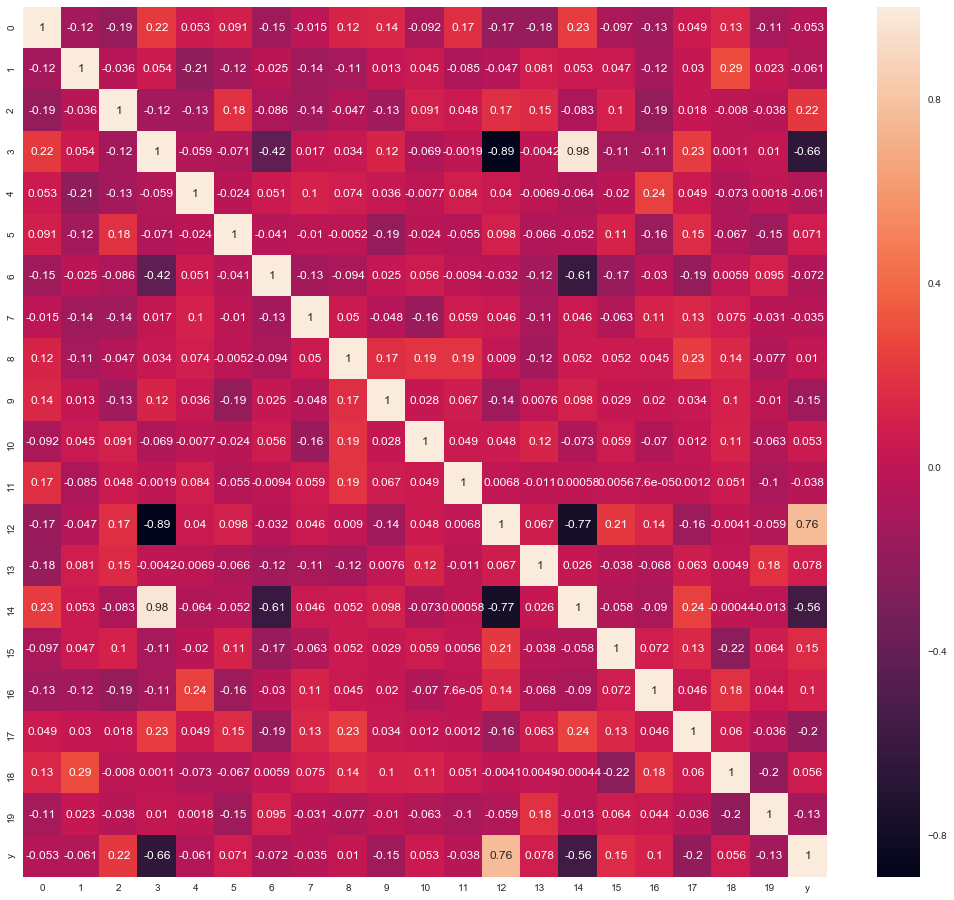

In [77]:
% matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(18,16)})
sns.heatmap(xy.corr(), annot=True)

С зависимой переменной коррелируют признаки 3, 12 и 14, но у них сильная корреляция между собой. Оставляем 12 и добавляем признаки, на которых растет метрика.

In [88]:
X2 = X[[2,12,15]]
score2 = cross_val_score(LogisticRegression(), X2, y_data_generated, scoring='accuracy').mean()
score2

0.9197860962566845

Отсечение низковариативных признаков не сработало. Все признаки остались.

In [91]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X3 = selector.fit_transform(X)
score3 = cross_val_score(LogisticRegression(), X3, y_data_generated, scoring='accuracy').mean()
score3

0.81996434937611407

In [92]:
X3.shape

(100, 20)

Вычисляем метрику для SelectKBest

In [95]:
from sklearn.feature_selection import SelectKBest
X4 = SelectKBest(k=5).fit_transform(X, y_data_generated)
score4 = cross_val_score(LogisticRegression(), X4, y_data_generated, scoring='accuracy').mean()
score4

0.9093879976232917

Используем L1 регуляризацию для отбора признаков. На полученном датасете вычисляем метрику для логистической регрессии.

In [96]:
clf = LogisticRegression(penalty="l1",solver="liblinear",tol=1e-6, max_iter=1000000, warm_start=True,intercept_scaling=10000.0)
clf.fit(X, y_data_generated)
clf.coef_

array([[  1.78469928e-01,   0.00000000e+00,   4.82745479e-01,
          0.00000000e+00,  -4.15211075e-01,   0.00000000e+00,
         -7.23138359e-01,  -4.16633330e-01,   0.00000000e+00,
         -1.20723267e-01,   1.53589158e-01,  -4.99274526e-04,
          3.10835538e+00,   1.27727255e-02,   0.00000000e+00,
          0.00000000e+00,   8.94313205e-02,  -6.11319265e-01,
         -1.05202080e-01,  -6.70237312e-01]])

In [108]:
X5 = X.drop([1,3,5,8,14,15], axis=1)
X5.shape

(100, 14)

In [109]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=LogisticRegression(),threshold='median').fit(X5, y_data_generated)
X5 = selector.transform(X5)
score5 = cross_val_score(LogisticRegression(), X5, y_data_generated, scoring='accuracy').mean()
score5

0.8698752228163994

Вычисляем метрику для случайного леса

In [111]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=1)
model.fit(X, y_data_generated)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [113]:
imps = pd.Series(model.feature_importances_)
imps.sort_values()

7     0.004504
19    0.007526
8     0.012846
5     0.012915
0     0.013427
13    0.017002
4     0.017318
2     0.018889
18    0.019540
9     0.022835
11    0.023856
10    0.026548
1     0.031178
17    0.033627
16    0.038545
6     0.039563
15    0.040395
3     0.055879
14    0.188761
12    0.374846
dtype: float64

In [119]:
X6 = X[[12,14,3,15,6]]
score6 = cross_val_score(LogisticRegression(), X6, y_data_generated, scoring='accuracy').mean()
score6

0.90968508615567434

In [121]:
df = pd.DataFrame([['Необработанные данные',X.shape[1], score1],
                  ['Обработка корреляции',X2.shape[1], score2],
                  ['VarianceThreshold',X3.shape[1], score3],
                  ['SelectKBest',X4.shape[1], score4],
                  ['Логистическая регрессия',X5.shape[1], score5],
                  ['Случайный лес',X6.shape[1], score6]],
columns=['Способ выбора признаков','Количество признаков', 'Средняя точность модели'])
df

,Способ выбора признаков,Количество признаков,Средняя точность модели
0,Необработанные данные,20,0.819964
1,Обработка корреляции,3,0.919786
2,VarianceThreshold,20,0.819964
3,SelectKBest,5,0.909388
4,Логистическая регрессия,7,0.869875
5,Случайный лес,5,0.909685
